In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import torch.optim as optim
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm
import wandb

# wandb.init(project="unet-fish", entity="junta")


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Contracting Path
        self.enc1 = self.contracting_block(3, 64)
        self.enc2 = self.contracting_block(64, 128)
        self.enc3 = self.contracting_block(128, 256)
        self.enc4 = self.contracting_block(256, 512)
        # Bottleneck
        self.bottleneck = self.contracting_block(512, 1024)
        # Expanding Path
        self.upconv4 = self.expanding_block(1024, 512)
        self.upconv3 = self.expanding_block(512, 256)
        self.upconv2 = self.expanding_block(256, 128)
        self.upconv1 = self.expanding_block(128, 64)
        # Final layer
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def contracting_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )
        return block

    def expanding_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )
        return block

    def forward(self, x):
        # Contracting Path
        enc1 = self.enc1(x)
        enc2 = self.enc2(nn.MaxPool2d(2)(enc1))
        enc3 = self.enc3(nn.MaxPool2d(2)(enc2))
        enc4 = self.enc4(nn.MaxPool2d(2)(enc3))
        # Bottleneck
        bottleneck = self.bottleneck(nn.MaxPool2d(2)(enc4))
        # Expanding Path
        dec4 = self.upconv4(bottleneck)
        dec3 = self.upconv3(dec4 + enc4)
        dec2 = self.upconv2(dec3 + enc3)
        dec1 = self.upconv1(dec2 + enc2)
        # Final layer
        return torch.sigmoid(self.final(dec1 + enc1))



In [3]:
class FishDataset(Dataset):
    def __init__(self, image_root, mask_root, transform_image=None, transform_mask=None):
        self.image_root = image_root
        self.mask_root = mask_root
        self.transform_image = transform_image
        self.transform_mask = transform_mask
        self.image_folders = sorted([os.path.join(image_root, folder) for folder in os.listdir(image_root)])
        self.mask_folders = sorted([os.path.join(mask_root, folder) for folder in os.listdir(mask_root)])

        # Collect all image and mask paths
        self.image_paths = []
        self.mask_paths = []
        for image_folder, mask_folder in zip(self.image_folders, self.mask_folders):
            images = os.listdir(image_folder)
            for img in images:
                img_path = os.path.join(image_folder, img)
                mask_path = os.path.join(mask_folder, img.replace('fish', 'mask'))
                
                # Check if both image and mask exist
                if os.path.exists(mask_path):
                    self.image_paths.append(img_path)
                    self.mask_paths.append(mask_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform_image and self.transform_mask:
            image = self.transform_image(image)
            mask = self.transform_mask(mask)

        return image, mask

In [4]:

transform_image = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust size as per your model's requirement
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Adjust based on your training
                         std=[0.229, 0.224, 0.225])
])

transform_mask = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust size as per your model's requirement
    transforms.ToTensor(),
])

image_root = 'fish_image'
mask_root = 'mask_image'
dataset = FishDataset(image_root, mask_root, transform_image=transform_image, transform_mask=transform_mask)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


In [5]:
def dice_coefficient(preds, targets, threshold=0.5):
    # Apply threshold to get binary masks
    preds = (preds > threshold).float()
    # Calculate intersection and union
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum()

    # Compute Dice coefficient
    dice = (2. * intersection + 1e-8) / (union + 1e-8)  # Adding a small epsilon to avoid division by zero
    return dice.item()

In [6]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, loss function, and optimizer
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Assuming your model is defined and moved to the appropriate device
summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
            Conv2d-5        [-1, 128, 112, 112]          73,856
              ReLU-6        [-1, 128, 112, 112]               0
            Conv2d-7        [-1, 128, 112, 112]         147,584
              ReLU-8        [-1, 128, 112, 112]               0
            Conv2d-9          [-1, 256, 56, 56]         295,168
             ReLU-10          [-1, 256, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         590,080
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 512, 28, 28]       1,180,160
             ReLU-14          [-1, 512,

In [ ]:
# Training and Validation Loop with Dice Metric
epochs = 30
for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    running_train_dice = 0.0  # To accumulate Dice scores
    total_train = 0

    # Training loop with tqdm
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")
    for images, masks in progress_bar:
        images, masks = images.to(device).float(), masks.to(device).float()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

        # Calculate Dice score
        dice_score = dice_coefficient(outputs, masks)
        running_train_dice += dice_score
        total_train += 1

    train_loss = running_train_loss / len(train_loader)
    train_dice = running_train_dice / total_train

    # Validation loop
    model.eval()
    running_test_loss = 0.0
    running_test_dice = 0.0  # To accumulate Dice scores
    total_test = 0
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device).float(), masks.to(device).float()
            outputs = model(images)
            loss = criterion(outputs, masks)
            running_test_loss += loss.item()

            # Calculate Dice score
            dice_score = dice_coefficient(outputs, masks)
            running_test_dice += dice_score
            total_test += 1

    test_loss = running_test_loss / len(test_loader)
    test_dice = running_test_dice / total_test

    # Log the results to Weights & Biases
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_dice": train_dice,
        "test_loss": test_loss,
        "test_dice": test_dice
    })

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}, Test Loss: {test_loss:.4f}, Test Dice: {test_dice:.4f}")


In [1]:
torch.save(model.state_dict(), "unet.pt")

NameError: name 'torch' is not defined

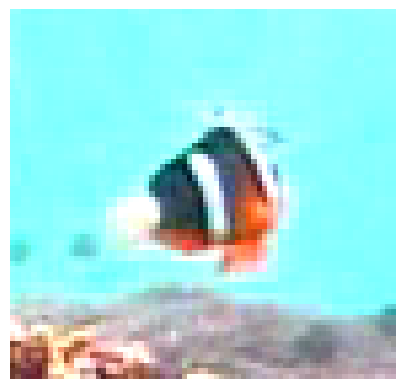

In [7]:
import random
import matplotlib.pyplot as plt
import os

image_folders = sorted([os.path.join("fish_image", folder) for folder in os.listdir("fish_image")])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_paths = []
for image_folder in image_folders:
    images = os.listdir(image_folder)
    for img in images:
        img_path = os.path.join(image_folder, img)
        image_paths.append(img_path)


# Define the transformations (ensure they match those used during U-Net training)
unet_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Adjust size as per your model's requirement
    transforms.ToTensor(),
])


# Load your pre-trained U-Net model
unet_model = UNet()
unet_model.load_state_dict(torch.load('unet.pt', map_location='cpu', weights_only=True))
unet_model.eval()
unet_model.to(device)  # Send model to CPU or GPU

# Load and preprocess the input image
random_img = random.choice(image_paths)
img_class = int(random_img.split("/")[1].split("_")[1]) - 1
image = Image.open(random_img).convert('RGB')  # Replace with your image path
input_image = unet_transform(image).unsqueeze(0).to(device)  # Add batch dimension and send to device

# Get the segmentation mask from U-Net
with torch.no_grad():
    segmentation_mask = unet_model(input_image)  # Output shape: [1, 1, H, W]
    
plt.imshow(image)
plt.axis('off')  # Turn off axis
plt.show()

In [13]:
import os
import random
import numpy as np
from PIL import Image

model = UNet().to(device)
model.load_state_dict(
    torch.load("unet.pt", map_location="cpu", weights_only=True)
)
model.eval()

# Define the root directory for fish images
root_dir = 'fish_image'

# Get a list of all subfolders
subfolders = [os.path.join(root_dir, subfolder) for subfolder in os.listdir(root_dir)]

# Load the original image
original_image = Image.open(random_img).convert("RGB")
original_image = original_image.resize((128, 128))  # Resize to match the transformed size
original_image = np.array(original_image)  # Convert to NumPy array

# Perform the segmentation
test_image = input_image  # Apply the transform and move to device

model.eval()
with torch.no_grad():
    output = model(test_image)
    mask = (output.squeeze().cpu().numpy() > 0.5).astype('uint8')  # Convert mask to binary

# Find the bounding box of the fish in the mask
coords = np.argwhere(mask)
y_min, x_min = coords.min(axis=0)
y_max, x_max = coords.max(axis=0)

# Crop the original image and the mask using the bounding box
cropped_image = original_image[y_min:y_max+1, x_min:x_max+1]
cropped_mask = mask[y_min:y_max+1, x_min:x_max+1]

# Apply the cropped mask to the cropped image to ensure the background is removed
cropped_masked_image = cropped_image * np.expand_dims(cropped_mask, axis=-1)

# Display the cropped and masked image
plt.imshow(cropped_masked_image)
plt.axis('off')  # Turn off axis
plt.show()


ValueError: zero-size array to reduction operation minimum which has no identity

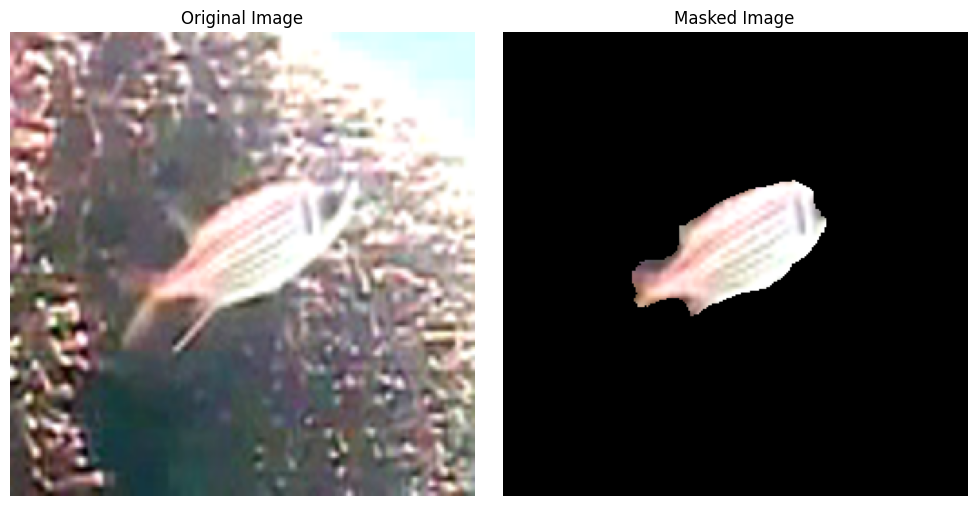

In [23]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import torch.optim as optim
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm
import wandb

# Define the root directory for fish images
root_dir = 'fish_image'

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
model.load_state_dict(
    torch.load("unet.pt", map_location="cpu", weights_only=True)
)
model.eval()


# Get a list of all subfolders
subfolders = [os.path.join(root_dir, subfolder) for subfolder in os.listdir(root_dir)]

# Choose a random subfolder and a random image within that subfolder
random_subfolder = random.choice(subfolders)
images = os.listdir(random_subfolder)
random_image_name = random.choice(images)
random_image_path = os.path.join(random_subfolder, random_image_name)

# Load the original image
original_image = Image.open(random_image_path).convert("RGB")
original_image = original_image.resize((256, 256))    # Resize to match the transformed size
original_image = np.array(original_image)  # Convert to NumPy array

# Perform the segmentation
test_image = transform(Image.open(random_image_path).convert("RGB")).unsqueeze(0).to(device)  # Apply the transform and move to device

model.eval()
with torch.no_grad():
    output = model(test_image)
    mask = (output.squeeze().cpu().numpy() > 0.5).astype('uint8')  # Convert mask to binary



# Apply the cropped mask to the cropped image to ensure the background is removed
masked_image = original_image * np.expand_dims(mask, axis=-1)

# Display the cropped and masked image
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Original image
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[0].axis("off")  # Turn off axis

# Masked image
axes[1].imshow(masked_image)
axes[1].set_title("Masked Image")
axes[1].axis("off")  # Turn off axis

# Show the side-by-side comparison
plt.tight_layout()
plt.show()
